# Bias and variance of Gamma gradient estimates

In [1]:
import torch
from torch.autograd import Variable, grad
from pyro.distributions.torch.gamma import Gamma
from rejection_gamma import RejectionStandardGamma, ShapeAugmentedStandardGamma, kl_gamma_gamma

import numpy as np
import scipy.stats
from matplotlib import pyplot
%matplotlib inline

First let's verify that the samplers are implemented correctly.

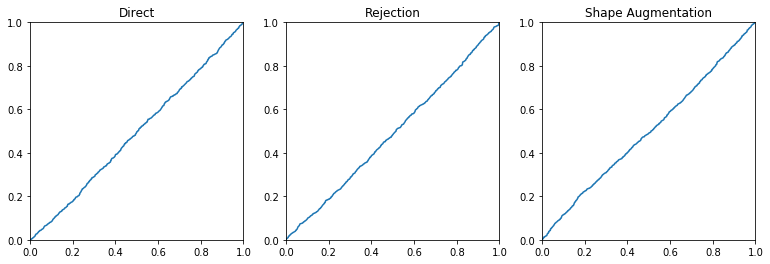

In [2]:
alpha0 = 1.2
alpha = Variable(alpha0 * torch.ones(1000), requires_grad=True)
beta = Variable(torch.ones(1000))
x = Gamma(alpha, beta).sample().data.numpy()
y = RejectionStandardGamma(alpha).sample().data.numpy()
z = ShapeAugmentedStandardGamma(alpha, 1).sample().data.numpy()
x.sort(); y.sort(); z.sort()
rank = (np.arange(len(alpha)) + 0.5) / len(alpha)
fig, axes = pyplot.subplots(1, 3, figsize=(13,4))
fig.patch.set_color('white')
for ax, sample, name in zip(axes, [x, y, z], ['Direct', 'Rejection', 'Shape Augmentation']):
    ax.plot(rank, scipy.stats.gamma(alpha0).cdf(sample))
    ax.set_title(name)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
pyplot.show()

Next consider the pointwise reparameterized gradient.

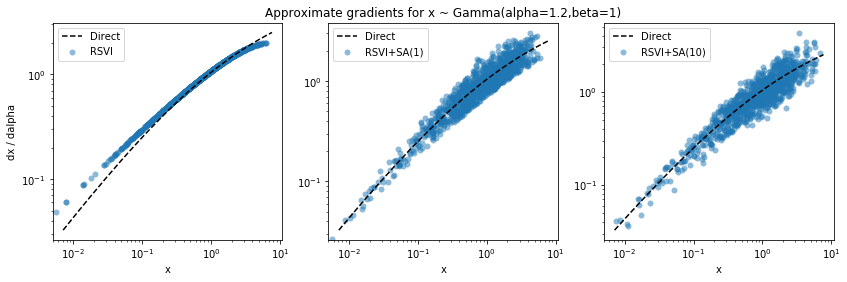

In [3]:
samples = {
    'Direct': Gamma(alpha, beta).sample(),
    'RSVI': RejectionStandardGamma(alpha).sample(),
    'RSVI+SA(1)': ShapeAugmentedStandardGamma(alpha, 1).sample(),
    'RSVI+SA(10)': ShapeAugmentedStandardGamma(alpha, 10).sample(),
}
x_dx = {}
for name, x in samples.items():
    dx, = grad([x.sum()], [alpha], retain_graph=True)
    x, ind = x.data.sort()
    x = x.numpy()
    dx = dx.data[ind].numpy()
    x_dx[name] = x, dx
    
fig, axes = pyplot.subplots(1, 3, figsize=(14,4))
fig.patch.set_color('white')
for ax, name in zip(axes, ['RSVI', 'RSVI+SA(1)', 'RSVI+SA(10)']):
    x, dx = x_dx['Direct']
    ax.plot(x, dx, 'k--', label='Direct')
    x, dx = x_dx[name]
    ax.scatter(x, dx, label=name, alpha=0.5, lw=0)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_xscale('log')
    ax.set_yscale('log')
axes[0].set_ylabel('dx / dalpha')
axes[1].set_title('Approximate gradients for x ~ Gamma(alpha={:0.2g},beta=1)'.format(alpha0))
pyplot.show()

Let's measure the variance of these gradient estimates in the context of VI. Consider fitting one standard gamma distribution to another, say a `guide` to a `model`. There is only a single parameter to optimize: `alpha`.

In [4]:
def surrogate_elbo(Guide, alpha1):
    model = Gamma(alpha1.new([alpha0]).expand_as(alpha1),
                  alpha1.new([1]).expand_as(alpha1))
    guide = Guide(alpha1)
    x = guide.sample()
    model_log_pdf = model.batch_log_pdf(x)
    guide_log_pdf, score_function, entropy_term = guide.score_parts(x)
    # print('{} {} {} {}'.format(*[getattr(p, 'shape', p) for p in [
    #     model_log_pdf, guide_log_pdf, score_function, entropy_term
    # ]]))
    log_r = model_log_pdf - guide_log_pdf
    return model_log_pdf - entropy_term + log_r.detach() * score_function

def grad_elbo(Guide, alpha1, num_particles=1000):
    alphas = Variable(torch.Tensor([alpha1]).expand(num_particles, 1), requires_grad=True)
    return grad([surrogate_elbo(Guide, alphas).sum()], [alphas])[0].data.numpy()

def grad_true(alphas):
    q_alpha = Variable(torch.Tensor(alphas), requires_grad=True)
    p_alpha = q_alpha.new([alpha0]).expand_as(q_alpha)
    beta = q_alpha.new([1]).expand_as(q_alpha)
    kl = kl_gamma_gamma(Gamma(q_alpha, beta), Gamma(p_alpha, beta))
    return grad([-kl.sum()], [q_alpha])[0].data.numpy()

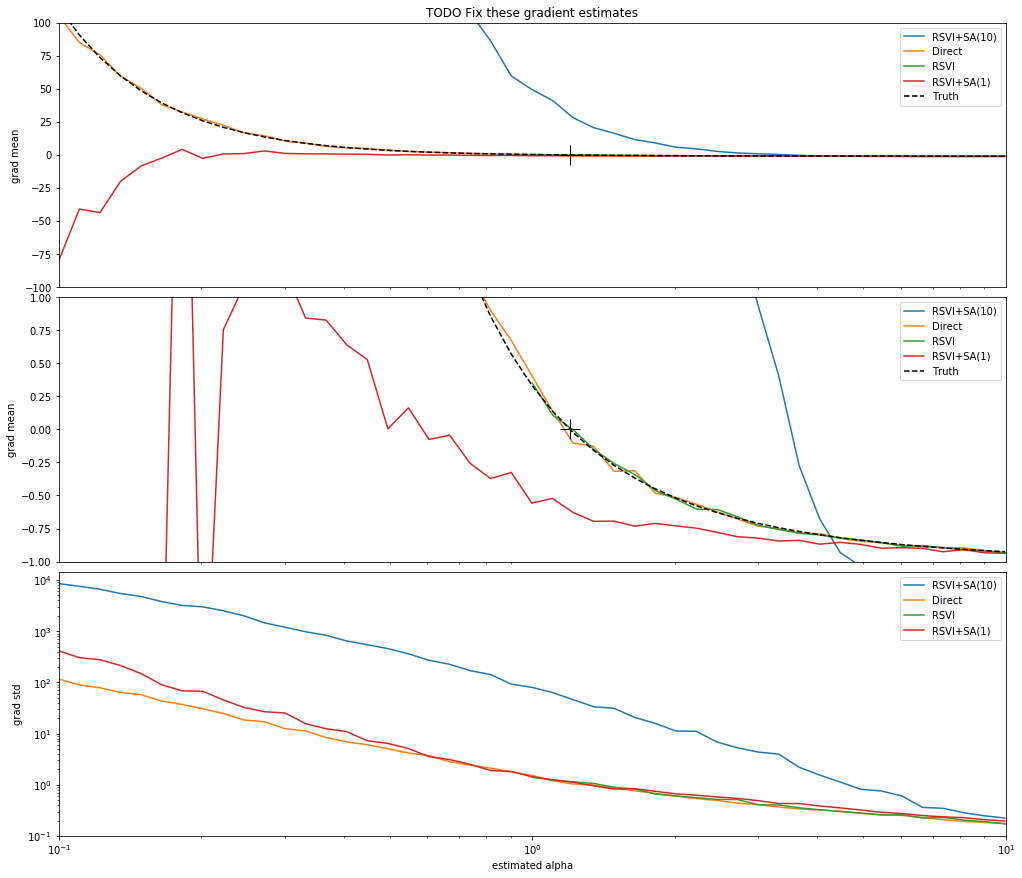

In [5]:
Guides = {
    'Direct': lambda a: Gamma(a, a.new([1]).expand_as(a)),
    'RSVI': lambda a: RejectionStandardGamma(a),
    'RSVI+SA(1)': lambda a: ShapeAugmentedStandardGamma(a, 1),
    'RSVI+SA(10)': lambda a: ShapeAugmentedStandardGamma(a, 10),
}
fig, axes = pyplot.subplots(3, 1, figsize=(14,12))
fig.patch.set_color('white')
for name, Guide in Guides.items():
    if name == 'RSVI':  # RSVI Gamma only works for alpha >= 1.
        alphas = np.exp(np.arange(0, np.log(10.0), 0.1))
    else:
        alphas = np.exp(np.arange(np.log(0.1), np.log(10.0), 0.1))
    means, stds = [], []
    for alpha in alphas:
        grads = grad_elbo(Guide, alpha)
        means.append(grads.mean())
        stds.append(grads.std())
    axes[0].plot(alphas, means, label=name)
    axes[1].plot(alphas, means, label=name)
    axes[2].plot(alphas, stds, label=name)
axes[0].plot(alphas, grad_true(alphas), 'k--', label='Truth')
axes[1].plot(alphas, grad_true(alphas), 'k--', label='Truth')
axes[0].plot([alpha0], [0], 'k+', markersize=20)
axes[1].plot([alpha0], [0], 'k+', markersize=20)
for ax in axes:
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlim(0.1, 10.0)
axes[0].set_ylim(-100, 100)
axes[1].set_ylim(-1, 1)
axes[2].set_yscale('log')
axes[0].set_ylabel('grad mean')
axes[1].set_ylabel('grad mean')
axes[2].set_ylabel('grad std')
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[-1].set_xlabel('estimated alpha')
axes[0].set_title('TODO Fix these gradient estimates')
pyplot.tight_layout(0)